In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Load MNIST with PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] and shape [1, 28, 28]
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine train and test datasets
full_data = torch.cat([mnist_dataset.data, mnist_test_dataset.data], dim=0)
full_targets = torch.cat([mnist_dataset.targets, mnist_test_dataset.targets], dim=0)

# Step 2: Normalize and flatten
full_data = full_data.view(-1, 28*28).float() / 255.0  # [70000, 784]
full_targets = full_targets.numpy()

# Step 3: PCA to reduce to 50 dims
pca = PCA(n_components=50)
X_pca = pca.fit_transform(full_data.numpy())
print(f"PCA retained {np.sum(pca.explained_variance_ratio_):.2%} of the variance.")

# Step 4: Split into Train (80%), Val (10%), Test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_pca, full_targets, test_size=0.2, stratify=full_targets, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42
)

# Final shapes
print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")



PCA retained 82.54% of the variance.
Train: 49778 samples
Val: 6222 samples
Test: 14000 samples


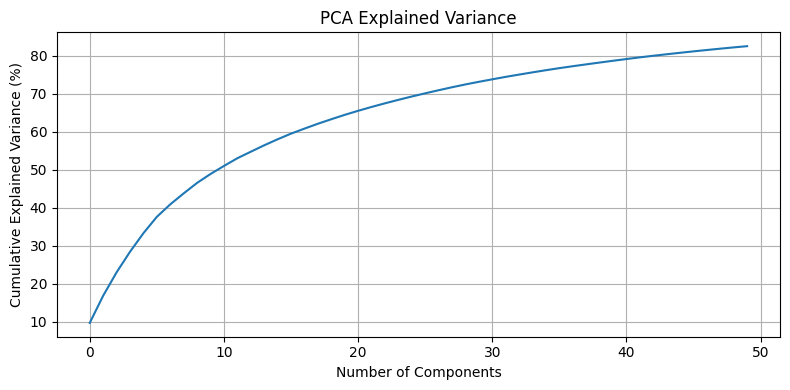

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


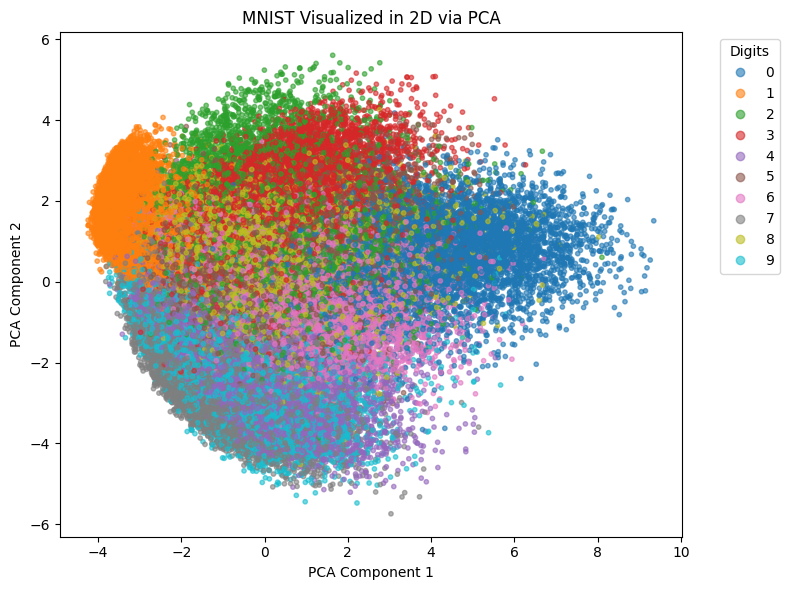

In [7]:
# Use only 2 components for visualization
pca_2d = PCA(n_components=50)
X_2d = pca_2d.fit_transform(full_data.numpy())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=full_targets, cmap='tab10', alpha=0.6, s=10)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MNIST Visualized in 2D via PCA')
plt.tight_layout()
plt.show()

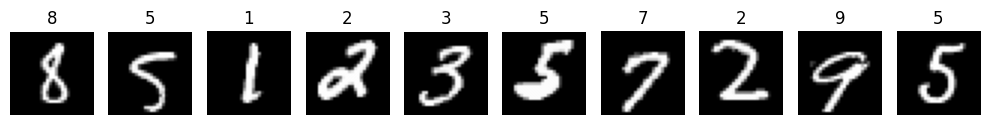

In [24]:
def show_samples(data, labels, n=10):
    plt.figure(figsize=(10, 1.5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title(f"{labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 10 random digits from original dataset
indices = np.random.choice(len(full_data), 10, replace=False)
show_samples(full_data[indices], full_targets[indices])


GMM Accuracy (after mapping clusters to digits): 0.6456


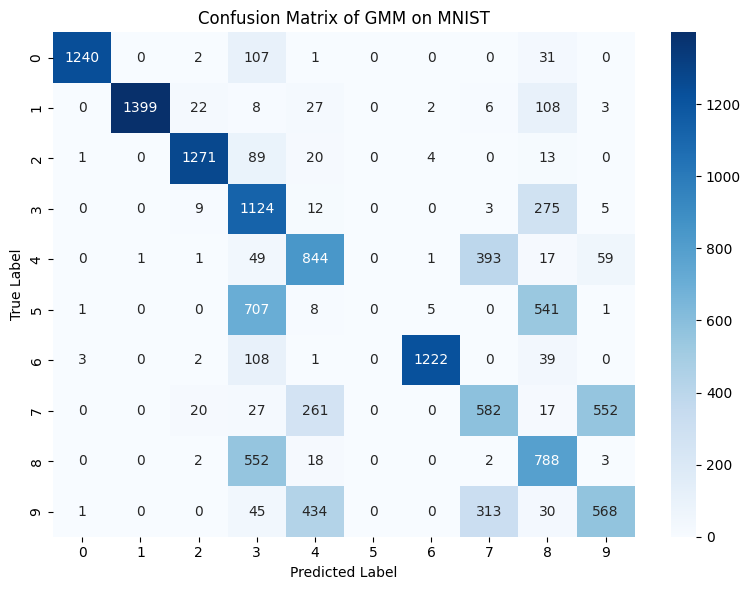

In [26]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Fit GMM with 10 components (digits 0–9)
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Step 2: Predict cluster assignments on test data
y_pred = gmm.predict(X_test)

# Step 3: Map GMM cluster labels to true digit labels using majority vote
def map_clusters_to_digits(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(10):
        mask = (y_pred == i)
        if np.any(mask):
            labels[mask] = mode(y_true[mask])[0]
    return labels

y_pred_mapped = map_clusters_to_digits(y_test, y_pred)

# Step 4: Evaluate accuracy
acc = accuracy_score(y_test, y_pred_mapped)
print(f"GMM Accuracy (after mapping clusters to digits): {acc:.4f}")

# Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mapped)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of GMM on MNIST')
plt.tight_layout()
plt.show()


GMM Accuracy with soft-label mapping: 0.8504


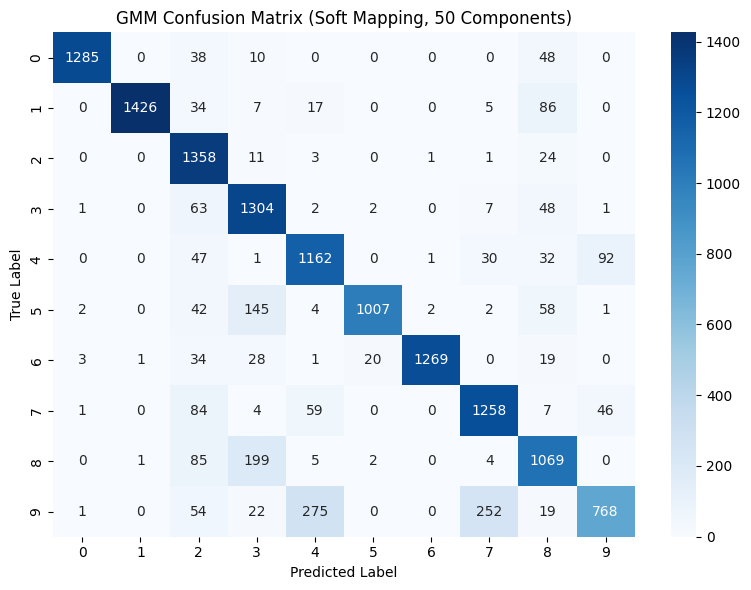

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Configurable Parameters ---
n_components = 50  # Number of GMM clusters (can be different from num_digits)
num_digits = 10    # Number of unique digit classes (for MNIST it's 10)

# Step 1: Fit GMM
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Step 2: Predict soft cluster assignments on test data
probs = gmm.predict_proba(X_test)  # shape: (num_samples, n_components)

# Step 3: Learn label distribution for each cluster from training data
train_clusters = gmm.predict(X_train)
label_distribution = np.zeros((n_components, num_digits))

for cluster_id in range(n_components):
    cluster_mask = (train_clusters == cluster_id)
    if np.any(cluster_mask):
        true_labels = y_train[cluster_mask]
        counts = np.bincount(true_labels, minlength=num_digits)
        label_distribution[cluster_id] = counts / counts.sum()

# Step 4: Predict digit labels using soft voting
digit_probs = probs @ label_distribution  # shape: (num_samples, num_digits)
y_pred_soft = np.argmax(digit_probs, axis=1)

# Step 5: Evaluate accuracy
acc_soft = accuracy_score(y_test, y_pred_soft)
print(f"GMM Accuracy with soft-label mapping: {acc_soft:.4f}")

# Step 6: Plot confusion matrix
cm_soft = confusion_matrix(y_test, y_pred_soft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_digits), yticklabels=range(num_digits))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'GMM Confusion Matrix (Soft Mapping, {n_components} Components)')
plt.tight_layout()
plt.show()


Ensemble GMM Accuracy: 0.9751


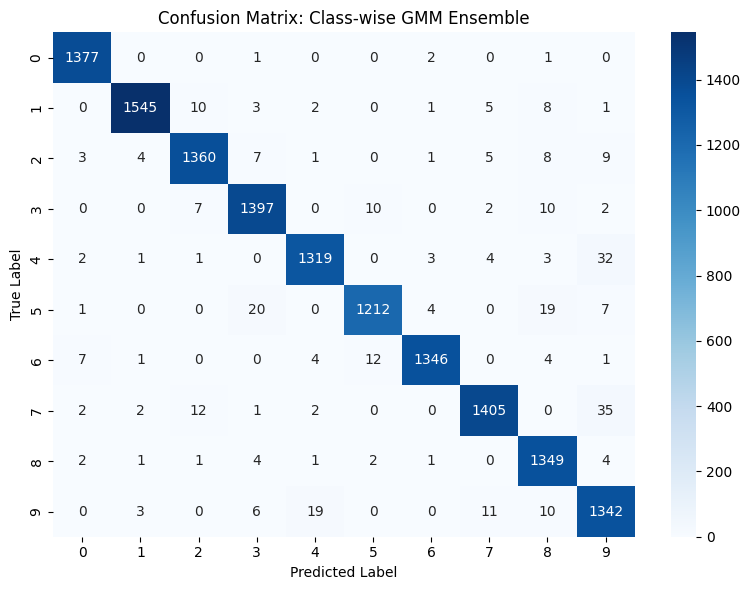

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
n_components = 10  # Number of Gaussians per class
num_classes = 10  # Digits 0 to 9

# Step 1: Train one GMM per class
gmm_models = {}
for digit in range(num_classes):
    # Extract samples of the current digit
    X_class = X_train[y_train == digit]
    
    # Train GMM for this class
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_class)
    
    gmm_models[digit] = gmm

# Step 2: Predict labels for test data based on maximum likelihood across class-GMMs
log_likelihoods = np.zeros((len(X_test), num_classes))  # shape: [num_samples, num_classes]

for digit, gmm in gmm_models.items():
    log_likelihoods[:, digit] = gmm.score_samples(X_test)  # log p(x | class)

# Assign label with highest log-likelihood
y_pred = np.argmax(log_likelihoods, axis=1)

# Step 3: Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Ensemble GMM Accuracy: {acc:.4f}")

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: Class-wise GMM Ensemble')
plt.tight_layout()
plt.show()


c:\Users\VICTUS\PycharmProjects\DL-Homework1\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Validation Accuracy: 0.7473
Test Accuracy: 0.7541


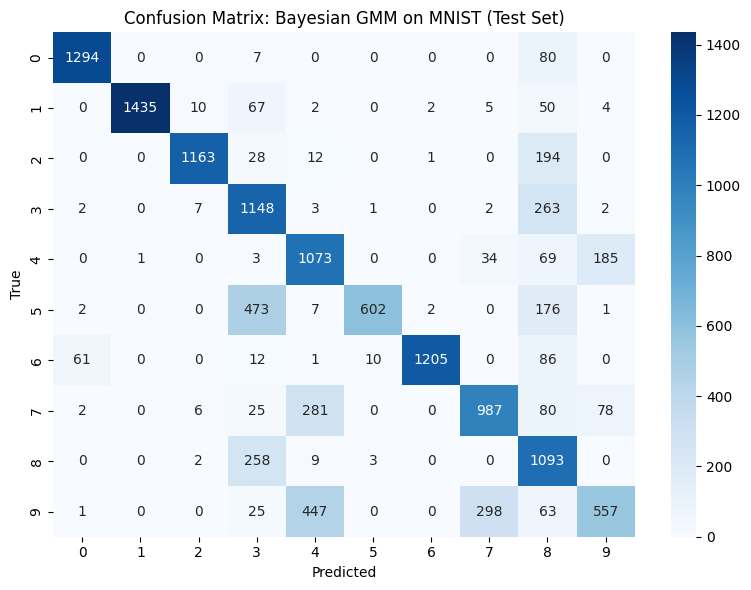

In [5]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Fit Bayesian GMM on training data
n_components = 20  # You can adjust this; BMM will prune unused clusters
bmm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=42,max_iter=100)
bmm.fit(X_train)

# Step 2: Predict soft assignments on train data to build label distribution
train_clusters = bmm.predict(X_train)

label_distribution = np.zeros((n_components, 10))  # 10 digit classes

for cluster_id in range(n_components):
    mask = (train_clusters == cluster_id)
    if np.any(mask):
        counts = np.bincount(y_train[mask], minlength=10)
        label_distribution[cluster_id] = counts / counts.sum()

# Step 3: Predict on validation and test sets using soft-label voting
def predict_with_soft_mapping(X, label_dist):
    probs = bmm.predict_proba(X)  # shape: (samples, n_components)
    digit_probs = probs @ label_dist
    return np.argmax(digit_probs, axis=1)

# Predict
y_val_pred = predict_with_soft_mapping(X_val, label_distribution)
y_test_pred = predict_with_soft_mapping(X_test, label_distribution)

# Step 4: Evaluate Accuracy
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {acc_val:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")

# Step 5: Confusion Matrix for Test Set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Bayesian GMM on MNIST (Test Set)")
plt.tight_layout()
plt.show()


c:\Users\VICTUS\PycharmProjects\DL-Homework1\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Validation Accuracy: 0.7554
Test Accuracy: 0.7624


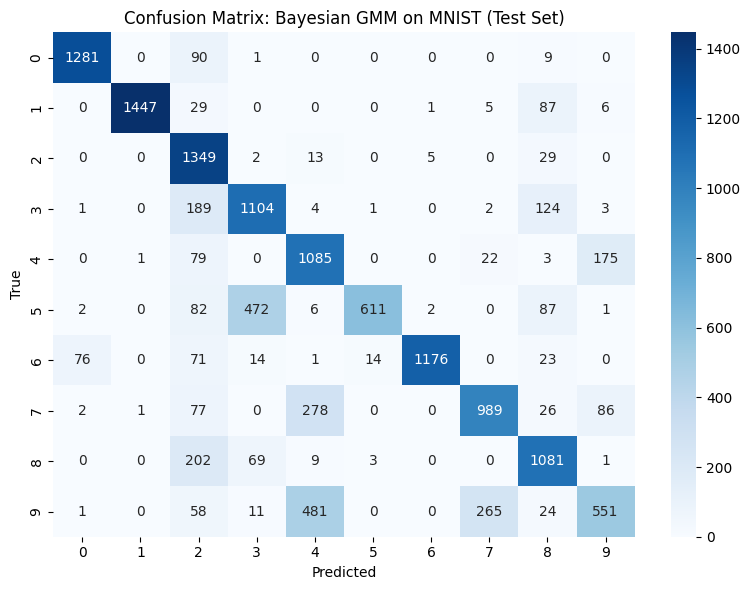

In [7]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Fit Bayesian GMM on training data
n_components = 20  # You can adjust this; BMM will prune unused clusters
bmm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=42,max_iter=100,n_init=3)
bmm.fit(X_train)

# Step 2: Predict soft assignments on train data to build label distribution
train_clusters = bmm.predict(X_train)

label_distribution = np.zeros((n_components, 10))  # 10 digit classes

for cluster_id in range(n_components):
    mask = (train_clusters == cluster_id)
    if np.any(mask):
        counts = np.bincount(y_train[mask], minlength=10)
        label_distribution[cluster_id] = counts / counts.sum()

# Step 3: Predict on validation and test sets using soft-label voting
def predict_with_soft_mapping(X, label_dist):
    probs = bmm.predict_proba(X)  # shape: (samples, n_components)
    digit_probs = probs @ label_dist
    return np.argmax(digit_probs, axis=1)

# Predict
y_val_pred = predict_with_soft_mapping(X_val, label_distribution)
y_test_pred = predict_with_soft_mapping(X_test, label_distribution)

# Step 4: Evaluate Accuracy
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {acc_val:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")

# Step 5: Confusion Matrix for Test Set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Bayesian GMM on MNIST (Test Set)")
plt.tight_layout()
plt.show()


Active components: 20
Number of active components: 20


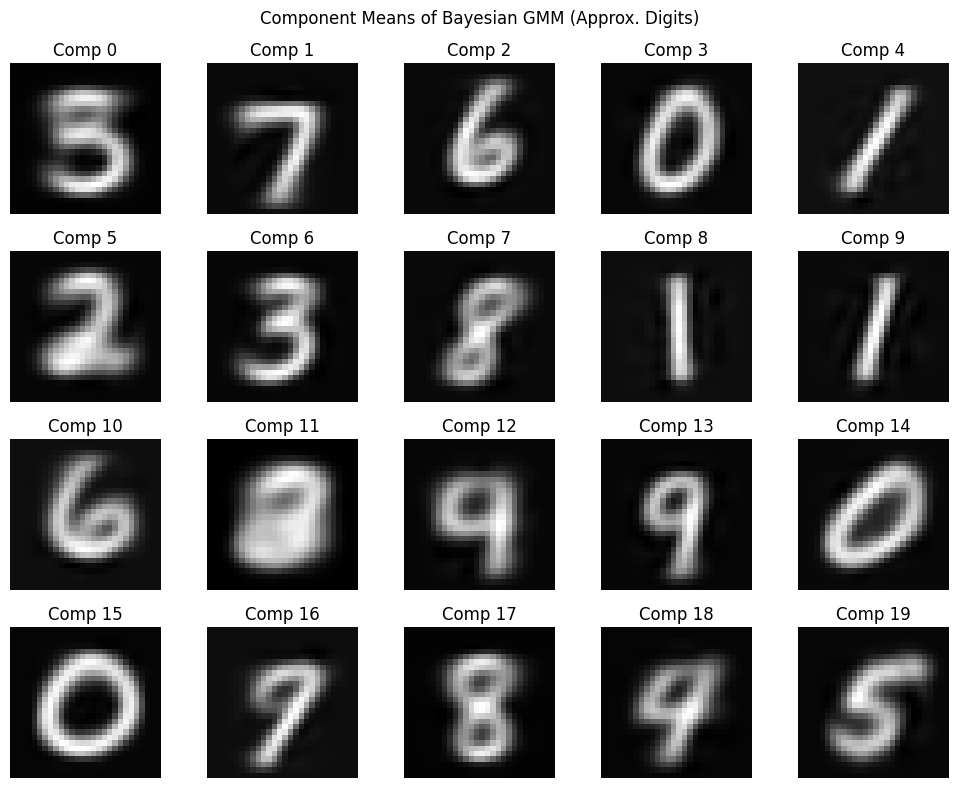

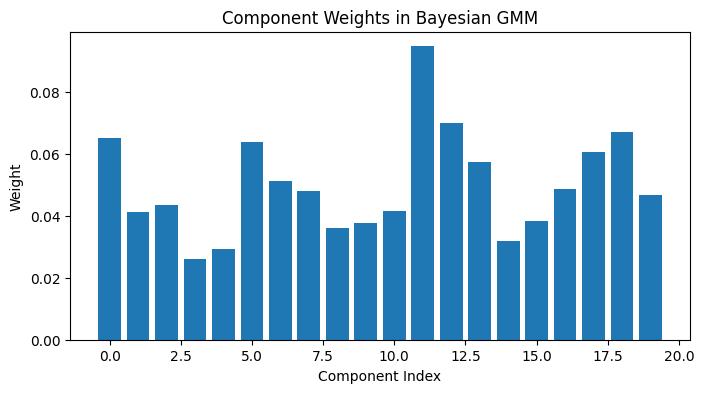

In [8]:
print("Active components:", np.sum(bmm.weights_ > 1e-2))
# Number of components to visualize (only those with non-negligible weight)
active_components = np.where(bmm.weights_ > 1e-2)[0]
print(f"Number of active components: {len(active_components)}")

# Create a grid of component means visualized as digits
import matplotlib.pyplot as plt

n_cols = 5
n_rows = int(np.ceil(len(active_components) / n_cols))
plt.figure(figsize=(n_cols * 2, n_rows * 2))

for idx, comp_idx in enumerate(active_components):
    mean_pca = bmm.means_[comp_idx]  # shape: [50]
    mean_image_flat = pca.inverse_transform(mean_pca)  # shape: [784]
    mean_image = mean_image_flat.reshape(28, 28)

    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Comp {comp_idx}")
    plt.axis('off')

plt.suptitle("Component Means of Bayesian GMM (Approx. Digits)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 4))
plt.bar(range(n_components), bmm.weights_)
plt.xlabel("Component Index")
plt.ylabel("Weight")
plt.title("Component Weights in Bayesian GMM")
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

class LaplaceRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

class LaplaceMixtureModel:
    def __init__(self, n_components=3, input_dim=50, lr=1e-2, max_iters=50, device='cpu'):
        self.K = n_components
        self.input_dim = input_dim
        self.lr = lr
        self.max_iters = max_iters
        self.device = device

        self.models = [LaplaceRegressor(input_dim).to(device) for _ in range(self.K)]
        self.optimizers = [optim.Adam(model.parameters(), lr=lr) for model in self.models]
        self.pi = torch.ones(self.K, device=device) / self.K  # Mixing coefficients

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)
        N = X.shape[0]

        for iter in tqdm(range(self.max_iters), desc="Training Laplace Mixture"):
            with torch.no_grad():
                # E-step: compute responsibilities
                likelihoods = []
                for model in self.models:
                    y_pred = model(X)
                    # Laplace likelihood (proportional to exp(-|y - y_pred|))
                    error = torch.abs(y - y_pred)
                    likelihood = torch.exp(-error)
                    likelihoods.append(likelihood)

                likelihoods = torch.cat(likelihoods, dim=1)  # [N, K]
                weighted_likelihoods = likelihoods * self.pi
                responsibilities = weighted_likelihoods / (weighted_likelihoods.sum(dim=1, keepdim=True) + 1e-8)  # [N, K]

            # M-step: update models with weighted L1 loss
            for k in range(self.K):
                self.optimizers[k].zero_grad()
                y_pred_k = self.models[k](X)
                loss_k = torch.mean(responsibilities[:, k].view(-1, 1) * torch.abs(y - y_pred_k))
                loss_k.backward()
                self.optimizers[k].step()

            # Update mixing coefficients π
            self.pi = responsibilities.mean(dim=0)

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = torch.cat([model(X) for model in self.models], dim=1)  # [N, K]
            weighted_preds = predictions * self.pi
            y_pred = weighted_preds.sum(dim=1)
            return y_pred.cpu().numpy(), predictions.cpu().numpy()

    def predict_labels(self, X):
        preds, _ = self.predict(X)
        return np.round(preds).astype(int)


In [3]:
# Assume you already have X_train, y_train, X_val, y_val, X_test, y_test
model = LaplaceMixtureModel(n_components=5, input_dim=50, max_iters=100, device='cpu')  # Use 'cuda' if GPU available
model.fit(X_train, y_train)

# Predict
y_pred_test, _ = model.predict(X_test)
y_pred_test_rounded = np.round(y_pred_test).astype(int)

# Accuracy
from sklearn.metrics import accuracy_score
print("Test Accuracy (Laplace Mixture, rounded):", accuracy_score(y_test, y_pred_test_rounded))


Training Laplace Mixture: 100%|██████████| 100/100 [00:01<00:00, 58.89it/s]

Test Accuracy (Laplace Mixture, rounded): 0.07857142857142857


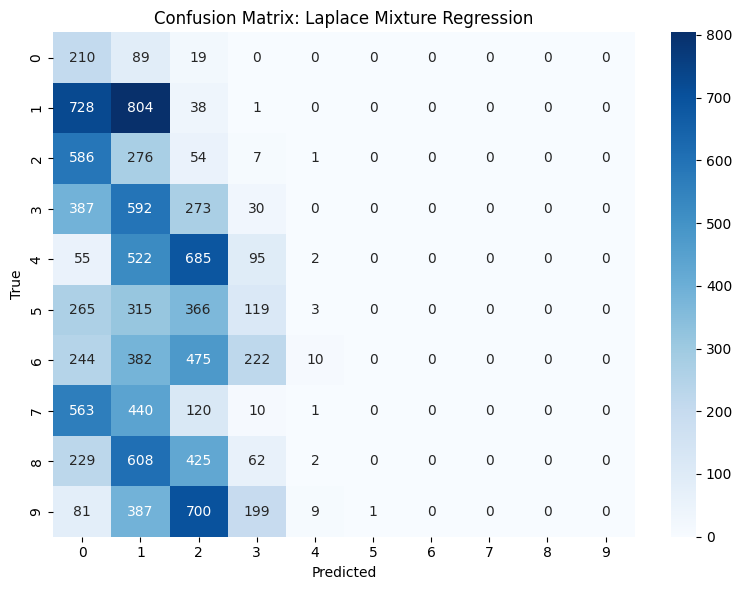

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test_rounded, labels=range(10))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Laplace Mixture Regression")
plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
def create_dataloader(X, y, batch_size=256):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train_tensor, y_train_tensor)
val_loader = create_dataloader(X_val_tensor, y_val_tensor, batch_size=len(X_val_tensor))
test_loader = create_dataloader(X_test_tensor, y_test_tensor, batch_size=len(X_test_tensor))

# Define Laplace-regularized logistic regression model
class LaplaceRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

# Training function with L1 regularization
def train_model(l1_strength, num_epochs=300, learning_rate=0.01):
    model = LaplaceRegression(X_train.shape[1], 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Add L1 regularization equivalent to Laplace prior
            l1_reg = torch.tensor(0., requires_grad=True)
            for param in model.parameters():
                if param.dim() == 2:  # Only regularize weights, not bias
                    l1_reg = l1_reg + torch.norm(param, p=1)
            
            total_loss = loss + l1_strength * l1_reg
            total_loss.backward()
            optimizer.step()
    
    # Validation accuracy
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_outputs = model(X_val)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc = accuracy_score(y_val.numpy(), val_preds.numpy())
    
    return val_acc, model

# Hyperparameter tuning (equivalent to b values from original code)
l1_strengths = [1.0/b for b in [0.01, 0.05, 0.1]]  # Convert to regularization strengths
best_acc = 0
best_model = None
best_strength = l1_strengths[0]

for strength in l1_strengths:
    val_acc, model = train_model(strength)
    print(f"L1 Strength: {strength:.2f}, Validation Accuracy: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        best_strength = strength

# Final test evaluation
best_model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        test_outputs = best_model(X_test)
        test_preds = torch.argmax(test_outputs, dim=1)
        test_acc = accuracy_score(y_test.numpy(), test_preds.numpy())

print(f"\nBest L1 Strength: {best_strength:.2f}")
print(f"Test Accuracy: {test_acc:.4f}")

L1 Strength: 100.00, Validation Accuracy: 0.1125
L1 Strength: 20.00, Validation Accuracy: 0.1003
L1 Strength: 10.00, Validation Accuracy: 0.1125

Best L1 Strength: 100.00
Test Accuracy: 0.1125


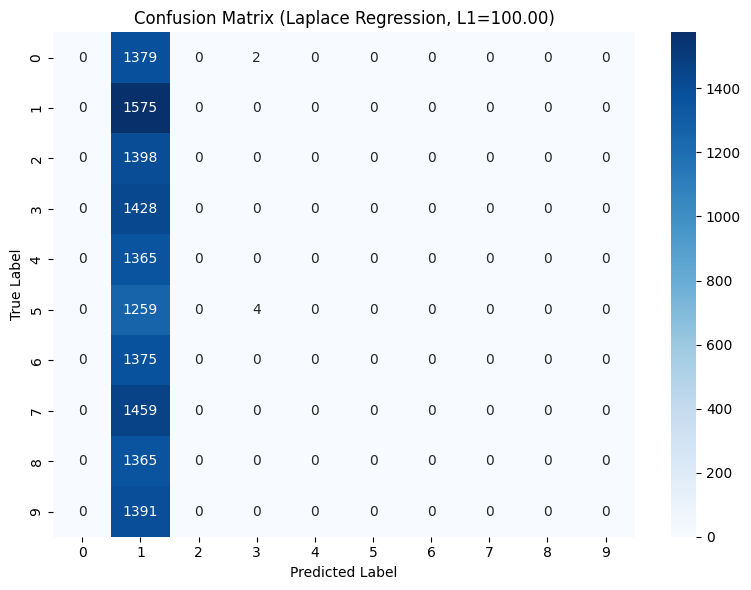

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test.numpy(), test_preds.numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Laplace Regression, L1={best_strength:.2f})')
plt.tight_layout()
plt.show()


PCA retained 82.54% of variance.
Train shape: (49778, 50)
Val shape: (6222, 50)
Test shape: (14000, 50)
Iteration 0, average beta change 0.018210
Iteration 10, average beta change 0.020888
Iteration 20, average beta change 0.014173
Iteration 30, average beta change 0.008735
Iteration 40, average beta change 0.031920
Iteration 50, average beta change 0.039838
Iteration 60, average beta change 0.010937
Iteration 70, average beta change 0.002188
Iteration 80, average beta change 0.002739
Iteration 90, average beta change 0.005649
Iteration 100, average beta change 0.001575
Iteration 110, average beta change 0.000250
Iteration 120, average beta change 0.000205
Iteration 130, average beta change 0.000162
Iteration 140, average beta change 0.000127
Converged in 149 iterations.
Train MSE: 26.213652885710385
Val   MSE: 26.510333475198877
Test  MSE: 26.507678077368844
Train Accuracy: 0.12007312467355057
Val Accuracy:   0.11989713918354226
Test Accuracy:  0.11914285714285715


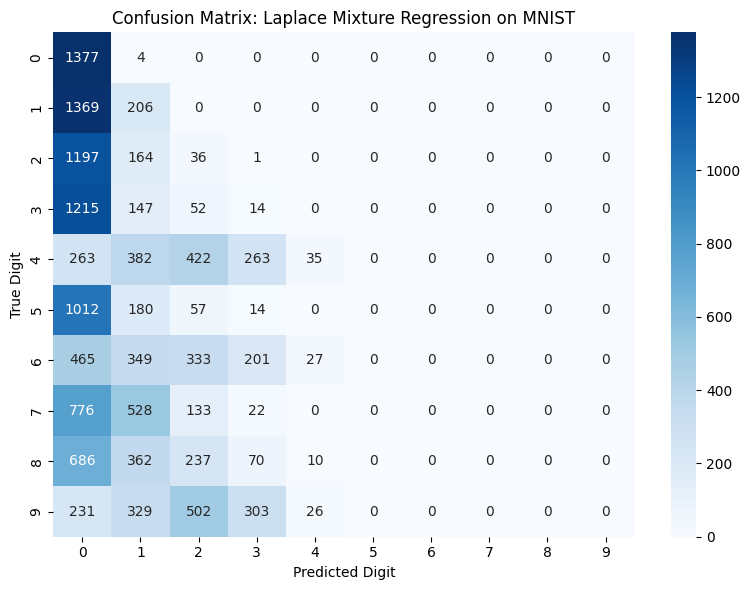

In [4]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

### 1. Load and Preprocess MNIST

# Load MNIST using PyTorch
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine train and test datasets
full_data = torch.cat([mnist_train.data, mnist_test.data], dim=0)
full_targets = torch.cat([mnist_train.targets, mnist_test.targets], dim=0)

# Flatten (28x28 -> 784) and normalize pixel values to [0,1]
X_all = full_data.view(-1, 28*28).float() / 255.0   # shape (70000, 784)
# Use digit labels as continuous regression targets (0.0 to 9.0)
Y_all = full_targets.numpy().astype(np.float64)

# Apply PCA to reduce dimensionality from 784 to 50
pca = PCA(n_components=50, random_state=42)
X_all_pca = pca.fit_transform(X_all.numpy())
print(f"PCA retained {np.sum(pca.explained_variance_ratio_):.2%} of variance.")

# Split data into training (approx. 71%), validation (approx. 9%), and test sets (20%)
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_all_pca, Y_all, test_size=0.2, stratify=full_targets.numpy(), random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.1111, stratify=Y_temp, random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


### 2. Define and Run the Laplace Mixture Regression EM Algorithm

def run_laplace_mixture_EM(X, Y, n_components=10, max_iter=200, tol=1e-4):
    """
    X: [n, d] feature matrix (PCA-reduced)
    Y: [n,] target values (continuous digits)
    n_components: number of mixture regression components.
    Returns: beta (coefficients), sigma (noise scale), pi (mixing weights), tau (responsibilities)
    """
    n, d = X.shape
    # Initialize parameters:
    beta = np.random.randn(n_components, d)      # regression coefficients for each component
    sigma = np.ones(n_components)                  # scale (noise standard deviation) for each component
    pi = np.ones(n_components) / n_components      # mixing proportions (sum to 1)
    
    tau = np.zeros((n, n_components))
    eps = 1e-8  # small constant to prevent division by zero
    
    for iteration in range(max_iter):
        # ---------- E-Step ----------
        # Compute predictions for each component: shape (n, n_components)
        predictions = X @ beta.T
        # Compute absolute errors for each component
        errors = np.abs(Y[:, None] - predictions)  # shape (n, n_components)
        
        # Compute the unnormalized likelihood for each component:
        # L_ij = pi_i * exp(-sqrt(2)*error_ij / sigma_i)
        L = np.zeros((n, n_components))
        for i in range(n_components):
            L[:, i] = pi[i] * np.exp(-np.sqrt(2) * errors[:, i] / (sigma[i] + eps))
        # Normalize to obtain responsibilities tau
        tau_new = L / (np.sum(L, axis=1, keepdims=True) + eps)
        
        # Compute latent scale variable expectation:
        # delta_ij = sigma_i / (sqrt(2)*|Y_j - X_j^T beta_i|)
        delta = np.zeros((n, n_components))
        for i in range(n_components):
            delta[:, i] = sigma[i] / (np.sqrt(2) * (errors[:, i] + eps))
        
        # ---------- M-Step ----------
        beta_new = np.zeros_like(beta)
        sigma_new = np.zeros_like(sigma)
        pi_new = np.zeros_like(pi)
        for i in range(n_components):
            w = tau_new[:, i] * delta[:, i]  # weights for component i (n,)
            # Compute weighted least squares update for beta_i:
            # beta_i = (X^T diag(w) X)^{-1} (X^T diag(w) Y)
            XTWX = X.T @ (w[:, None] * X)
            XTWY = X.T @ (w * Y)
            beta_new[i] = np.linalg.solve(XTWX + 1e-6*np.eye(d), XTWY)
            
            # Update sigma_i:
            pred_i = X @ beta_new[i]
            num = 2 * np.sum(tau_new[:, i] * delta[:, i] * (Y - pred_i)**2)
            den = np.sum(tau_new[:, i])
            sigma_new[i] = np.sqrt(num / (den + eps))
            
            # Update mixing proportion:
            pi_new[i] = np.sum(tau_new[:, i]) / n
        
        # Check convergence on beta (average change)
        change = np.mean(np.abs(beta_new - beta))
        beta = beta_new
        sigma = sigma_new
        pi = pi_new
        tau = tau_new
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, average beta change {change:.6f}")
        if change < tol:
            print(f"Converged in {iteration} iterations.")
            break
        
    return beta, sigma, pi, tau

# Run the EM algorithm on training data:
n_components = 10  # You can adjust the number of mixture components
beta, sigma, pi, tau_train = run_laplace_mixture_EM(X_train, Y_train, n_components=n_components, max_iter=200, tol=1e-4)

### 3. Prediction

def predict_laplace_mixture(X, beta, pi):
    """
    Predicts target value as a weighted average of the individual component predictions.
    X: [n, d]
    beta: [k, d]
    pi: [k]
    Returns: predicted Y as a weighted sum.
    """
    # Compute component predictions:
    comp_preds = X @ beta.T  # shape (n, k)
    # Weighted average using the mixing coefficients:
    Y_pred = comp_preds @ pi   # note: using pi (the overall mixture weights)
    return Y_pred

# Get predictions on training, validation, and test sets:
Y_pred_train = predict_laplace_mixture(X_train, beta, pi)
Y_pred_val   = predict_laplace_mixture(X_val, beta, pi)
Y_pred_test  = predict_laplace_mixture(X_test, beta, pi)

### 4. Evaluation
# Since our targets are digits (0-9), we can compare by rounding predictions.
def discrete_accuracy(Y_true, Y_pred):
    Y_true = np.round(Y_true)
    Y_pred = np.clip(np.round(Y_pred), 0, 9)  # ensure within 0-9
    return accuracy_score(Y_true, Y_pred)

print("Train MSE:", mean_squared_error(Y_train, Y_pred_train))
print("Val   MSE:", mean_squared_error(Y_val, Y_pred_val))
print("Test  MSE:", mean_squared_error(Y_test, Y_pred_test))
print("Train Accuracy:", discrete_accuracy(Y_train, Y_pred_train))
print("Val Accuracy:  ", discrete_accuracy(Y_val, Y_pred_val))
print("Test Accuracy: ", discrete_accuracy(Y_test, Y_pred_test))

### 5. Confusion Matrix
Y_pred_test_disc = np.clip(np.round(Y_pred_test), 0, 9).astype(int)
Y_test_disc = np.round(Y_test).astype(int)
cm = confusion_matrix(Y_test_disc, Y_pred_test_disc, labels=range(10))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Digit")
plt.ylabel("True Digit")
plt.title("Confusion Matrix: Laplace Mixture Regression on MNIST")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.linalg import pinvh
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from tqdm import tqdm

class LaplaceMixtureRegression:
    def __init__(self, n_components=5, max_iter=100, tol=1e-4, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.fitted = False

    def _initialize_params(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Initialize using K-means clustering
        kmeans = KMeans(n_clusters=self.n_components, random_state=self.random_state)
        clusters = kmeans.fit_predict(X)
        
        self.pi_ = np.zeros(self.n_components)
        self.beta_ = np.zeros((self.n_components, n_features + 1))  # +1 for intercept
        self.sigma_ = np.ones(self.n_components)
        
        X_bias = np.c_[np.ones(n_samples), X]
        
        for i in range(self.n_components):
            mask = (clusters == i)
            if np.sum(mask) < 2:
                # Fallback to random initialization
                self.beta_[i] = np.random.randn(n_features + 1)
                continue
                
            # Initialize beta using OLS on cluster subset
            X_cluster = X_bias[mask]
            y_cluster = y[mask]
            self.beta_[i] = np.linalg.lstsq(X_cluster, y_cluster, rcond=None)[0]
            residuals = y_cluster - X_cluster.dot(self.beta_[i])
            self.sigma_[i] = np.mean(np.abs(residuals))
            self.pi_[i] = np.mean(mask)

        # Normalize mixing proportions
        self.pi_ += 1e-8  # Avoid zero probabilities
        self.pi_ /= self.pi_.sum()

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X_bias = np.c_[np.ones(n_samples), X]  # Add intercept
        
        self._initialize_params(X, y)
        
        prev_loglik = -np.inf
        eps = 1e-8  # Numerical stability
        
        for iteration in tqdm(range(self.max_iter)):
            # E-step
            log_tau = np.zeros((n_samples, self.n_components))
            delta = np.zeros((n_samples, self.n_components))
            
            for i in range(self.n_components):
                residuals = y - X_bias.dot(self.beta_[i])
                abs_residuals = np.abs(residuals) + eps
                
                # Log-likelihood calculation (Laplace distribution)
                log_likelihood = (np.log(self.pi_[i]) 
                                 - np.log(2*self.sigma_[i]/np.sqrt(2)) 
                                 - (np.sqrt(2)*abs_residuals)/self.sigma_[i])
                
                log_tau[:, i] = log_likelihood
                delta[:, i] = self.sigma_[i] / (np.sqrt(2)*abs_residuals)
            
            # Normalize tau using log-sum-exp for numerical stability
            max_log_tau = np.max(log_tau, axis=1, keepdims=True)
            log_tau_norm = log_tau - max_log_tau
            tau = np.exp(log_tau_norm)
            tau /= tau.sum(axis=1, keepdims=True)
            
            # M-step
            new_pi = tau.mean(axis=0)
            new_beta = np.zeros_like(self.beta_)
            new_sigma = np.zeros_like(self.sigma_)
            
            for i in range(self.n_components):
                # Update beta using weighted least squares
                weights = tau[:, i] * delta[:, i]
                X_weighted = X_bias * np.sqrt(weights)[:, np.newaxis]
                y_weighted = y * np.sqrt(weights)
                
                try:
                    beta_i = np.linalg.lstsq(X_weighted, y_weighted, rcond=None)[0]
                except np.linalg.LinAlgError:
                    beta_i = self.beta_[i]  # Keep previous if singular matrix
                
                new_beta[i] = beta_i
                
                # Update sigma
                residuals = y - X_bias.dot(beta_i)
                weighted_sq_res = weights * residuals**2
                sigma_sq = 2 * weighted_sq_res.sum() / (tau[:, i].sum() + eps)
                new_sigma[i] = np.sqrt(sigma_sq + eps)
            
            # Check convergence
            current_loglik = self._log_likelihood(X_bias, y)
            if np.abs(current_loglik - prev_loglik) < self.tol:
                break
            prev_loglik = current_loglik
            
            self.pi_ = new_pi
            self.beta_ = new_beta
            self.sigma_ = new_sigma
        
        self.fitted = True
        return self

    def _log_likelihood(self, X_bias, y):
        loglik = 0
        for i in range(self.n_components):
            residuals = y - X_bias.dot(self.beta_[i])
            term = self.pi_[i] * (np.sqrt(2)/(2*self.sigma_[i])) * \
                   np.exp(-np.sqrt(2)*np.abs(residuals)/self.sigma_[i])
            loglik += np.log(term + 1e-8).sum()
        return loglik

    def predict(self, X):
        if not self.fitted:
            raise ValueError("Model not fitted yet")
            
        X_bias = np.c_[np.ones(X.shape[0]), X]
        components_pred = X_bias.dot(self.beta_.T)  # [n_samples, n_components]
        return np.dot(components_pred, self.pi_)    # Weighted average

# Enhanced version for difficult digits
class EnhancedDigitModel:
    def __init__(self, difficult_digits=[5,6,7,8,9], n_components=8):
        self.digits = difficult_digits
        self.n_components = n_components
        self.models = {}
        
    def fit(self, X_train, y_train, X_val, y_val):
        # First filter for difficult digits
        mask = np.isin(y_train, self.digits)
        X_sub = X_train[mask]
        y_sub = y_train[mask].astype(float)
        
        # Train specialized model for difficult digits
        self.model = LaplaceMixtureRegression(n_components=self.n_components,
                                            max_iter=300, random_state=42)
        self.model.fit(X_sub, y_sub)
        
        # Validate
        y_pred = self.model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        print(f"Validation MSE for digits {self.digits}: {mse:.4f}")
        
    def predict(self, X):
        return self.model.predict(X)

# --------------------------------------------------
# Usage with MNIST data from previous preprocessing
# --------------------------------------------------

# Convert labels to float for regression task
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)

# y_train = y_train.numpy().astype(float)
# y_val = y_val.numpy().astype(float)
# y_test = y_test.numpy().astype(float)

# Base model for all digits
print("Training base model for all digits...")
base_model = LaplaceMixtureRegression(n_components=10, max_iter=150, random_state=42)
base_model.fit(X_train, y_train)

# Enhanced model for difficult digits
print("\nTraining enhanced model for digits 5-9...")
enhanced_model = EnhancedDigitModel(n_components=8)
enhanced_model.fit(X_train, y_train, X_val, y_val)

# Evaluation
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    acc = np.mean(np.round(y_pred) == y)
    print(f"MSE: {mse:.4f}, Accuracy: {acc:.4f}")

print("\nBase model performance:")
print("Test set:")
evaluate_model(base_model, X_test, y_test)

print("\nEnhanced model performance (digits 5-9 only):")
mask = np.isin(y_test, [5,6,7,8,9])
evaluate_model(enhanced_model, X_test[mask], y_test[mask])

# Robustness analysis (add 10% outliers)
np.random.seed(42)
corrupt_mask = np.random.choice(len(y_test), size=int(0.1*len(y_test)), replace=False)
y_test_corrupt = y_test.copy()
y_test_corrupt[corrupt_mask] = np.random.randint(0, 10, size=len(corrupt_mask))

print("\nRobustness test with 10% label corruption:")
print("Base model:")
evaluate_model(base_model, X_test, y_test_corrupt)
print("Enhanced model:")
evaluate_model(enhanced_model, X_test[mask], y_test_corrupt[mask])

Training base model for all digits...


100%|██████████| 150/150 [01:09<00:00,  2.16it/s]



Training enhanced model for digits 5-9...


 98%|█████████▊| 197/200 [00:36<00:00,  5.40it/s]

Validation MSE for digits [5, 6, 7, 8, 9]: 15.0314

Base model performance:
Test set:
MSE: 5.4925, Accuracy: 0.0904

Enhanced model performance (digits 5-9 only):
MSE: 1.9476, Accuracy: 0.2129

Robustness test with 10% label corruption:
Base model:
MSE: 5.8411, Accuracy: 0.0911
Enhanced model:
MSE: 3.1182, Accuracy: 0.1992


In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.stats import laplace, mode
import matplotlib.pyplot as plt
from tqdm import trange


class LaplacianMixtureModel:
    def __init__(self, n_components=10, max_iter=30, tol=1e-4, verbose=True):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _laplace_pdf(self, x, mu, b):
        return (1 / (2 * b)) * np.exp(-np.abs(x - mu) / b)

    def _e_step(self, X):
        N, D = X.shape
        resp = np.zeros((N, self.K))
        for k in range(self.K):
            pdf = np.prod(self._laplace_pdf(X, self.mu[k], self.b[k]), axis=1)
            resp[:, k] = self.pi[k] * pdf
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            mu_k = np.zeros(D)
            for d in range(D):
                sorted_idx = np.argsort(X[:, d])
                sorted_X = X[sorted_idx, d]
                sorted_weights = resp[sorted_idx, k]
                cum_weights = np.cumsum(sorted_weights)
                median_idx = np.searchsorted(cum_weights, Nk[k] / 2)
                mu_k[d] = sorted_X[median_idx]
            self.mu[k] = mu_k

            # Weighted scale (b)
            self.b[k] = np.sum(resp[:, k][:, None] * np.abs(X - self.mu[k]), axis=0) / Nk[k]

    def fit(self, X):
        N, D = X.shape
        rng = np.random.RandomState(42)
        self.mu = X[rng.choice(N, self.K, replace=False)]
        self.b = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training LMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_likelihood = np.sum(np.log(np.sum([
                    self.pi[k] * np.prod(self._laplace_pdf(X, self.mu[k], self.b[k]), axis=1)
                    for k in range(self.K)
                ], axis=0)))
                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")
            self.loss_history.append(log_likelihood)
            
        self.resp = resp

    def predict(self, X):
        resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            pdf = np.prod(self._laplace_pdf(X, self.mu[k], self.b[k]), axis=1)
            resp[:, k] = self.pi[k] * pdf
        return np.argmax(resp, axis=1)

    def plot_components(self, pca):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols  # Ceiling division

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.5 * n_cols, 1.5 * n_rows))
        axes = axes.flatten()

        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')

        # Hide unused subplots
        for k in range(self.K, len(axes)):
            axes[k].axis('off')

        plt.suptitle("LMM Component Means", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)  # Make space for title
        plt.show()


# =============================
# RUNNING & TESTING THE MODEL
# =============================

# Step 1: Load MNIST
mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

# Step 2: Use a subset and apply PCA
X_train = X[:10000]
y_train = y[:10000]
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Step 3: Train LMM
lmm = LaplacianMixtureModel(n_components=50, max_iter=50, verbose=True)
lmm.fit(X_train_pca)

# Step 4: Predict clusters
y_pred = lmm.predict(X_train_pca)

# Step 5: Cluster to label mapping (unsupervised)
label_map = {}
for k in range(lmm.K):  # Loop over all 50 clusters
    cluster_points = y_train[y_pred == k]
    if len(cluster_points) > 0:
        # Get most frequent true label for this cluster
        most_common = mode(cluster_points, keepdims=False).mode
        label_map[k] = int(most_common)
    else:
        label_map[k] = -1 

# Remap predictions to digit labels using the map
mapped_preds = np.array([label_map[cluster] for cluster in y_pred])

# Accuracy
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nMapped Clustering Accuracy (50→10): {accuracy * 100:.2f}%")

# Step 6: Visualize learned clusters
lmm.plot_components(pca)

# loss history plot
plt.figure(figsize=(10, 5))
plt.plot(lmm.loss_history)
plt.title("Log-Likelihood Loss History")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid()
plt.show()

Iter 3 | LogL: -497406.92:   6%|▌         | 3/50 [00:05<01:28,  1.88s/it]


KeyboardInterrupt: 

In [ ]:

# Step 1: Load MNIST
mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

# Step 2: Use a subset and apply PCA
X_train = X[:10000]
y_train = y[:10000]
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Step 3: Train LMM
lmm = LaplacianMixtureModel(n_components=50, max_iter=50, verbose=True)
lmm.fit(X_train_pca)

# Step 4: Predict clusters
y_pred = lmm.predict(X_train_pca)

# Step 5: Cluster to label mapping (unsupervised)
label_map = {}
for k in range(lmm.K):  # Loop over all 50 clusters
    cluster_points = y_train[y_pred == k]
    if len(cluster_points) > 0:
        # Get most frequent true label for this cluster
        most_common = mode(cluster_points, keepdims=False).mode
        label_map[k] = int(most_common)
    else:
        label_map[k] = -1 

# Remap predictions to digit labels using the map
mapped_preds = np.array([label_map[cluster] for cluster in y_pred])

# Accuracy
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nMapped Clustering Accuracy (50→10): {accuracy * 100:.2f}%")

# Step 6: Visualize learned clusters
lmm.plot_components(pca)

# loss history plot
plt.figure(figsize=(10, 5))
plt.plot(lmm.loss_history)
plt.title("Log-Likelihood Loss History")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid()
plt.show()

Iter 50 | LogL: -485964.06: 100%|██████████| 50/50 [01:27<00:00,  1.75s/it]



Clustering Accuracy after Hungarian Mapping: 19.90%


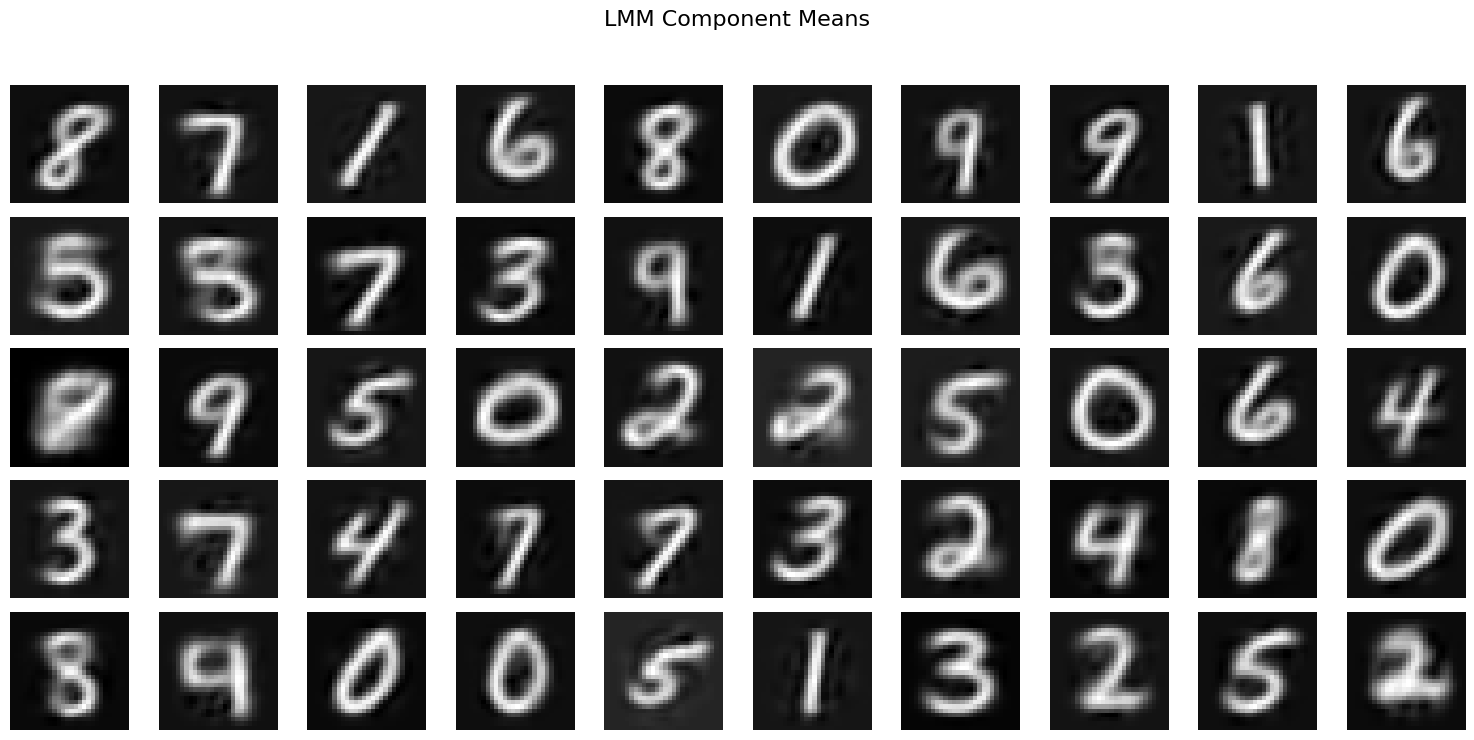

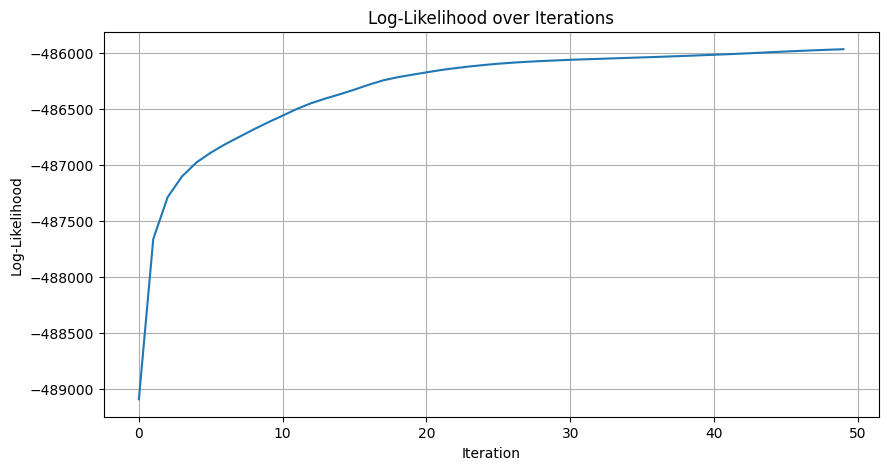

In [46]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from scipy.stats import laplace, mode
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from tqdm import trange


class LaplacianMixtureModel:
    def __init__(self, n_components=10, max_iter=30, tol=1e-4, verbose=True):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _laplace_pdf(self, x, mu, b):
        return (1 / (2 * b)) * np.exp(-np.abs(x - mu) / b)

    def _e_step(self, X):
        N, D = X.shape
        resp = np.zeros((N, self.K))
        for k in range(self.K):
            pdf = np.prod(self._laplace_pdf(X, self.mu[k], self.b[k]), axis=1)
            resp[:, k] = self.pi[k] * pdf
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            mu_k = np.zeros(D)
            for d in range(D):
                sorted_idx = np.argsort(X[:, d])
                sorted_X = X[sorted_idx, d]
                sorted_weights = resp[sorted_idx, k]
                cum_weights = np.cumsum(sorted_weights)
                median_idx = np.searchsorted(cum_weights, Nk[k] / 2)
                mu_k[d] = sorted_X[median_idx]
            self.mu[k] = mu_k
            self.b[k] = np.sum(resp[:, k][:, None] * np.abs(X - self.mu[k]), axis=0) / Nk[k]

    def fit(self, X):
        N, D = X.shape
        self._initialize_kmeans_pp(X)
        self.b = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training LMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_likelihood = np.sum(np.log(np.sum([
                    self.pi[k] * np.prod(self._laplace_pdf(X, self.mu[k], self.b[k]), axis=1)
                    for k in range(self.K)
                ], axis=0)))
                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")
            self.loss_history.append(log_likelihood)

        self.resp = resp

    def _initialize_kmeans_pp(self, X):
        kmeans = KMeans(n_clusters=self.K, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(X)
        self.mu = kmeans.cluster_centers_

    def predict(self, X):
        resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            pdf = np.prod(self._laplace_pdf(X, self.mu[k], self.b[k]), axis=1)
            resp[:, k] = self.pi[k] * pdf
        return np.argmax(resp, axis=1)

    def plot_components(self, pca):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.5 * n_cols, 1.5 * n_rows))
        axes = axes.flatten()
        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')
        for k in range(self.K, len(axes)):
            axes[k].axis('off')

        plt.suptitle("LMM Component Means", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

    def plot_log_likelihood(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.title("Log-Likelihood over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid()
        plt.show()


# ============================
# RUNNING & TESTING THE MODEL
# ============================

# Step 1: Load MNIST
mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

# Step 2: Subsample and PCA
X_train = X[:10000]
y_train = y[:10000]
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Step 3: Train LMM
lmm = LaplacianMixtureModel(n_components=50, max_iter=50, verbose=True)
lmm.fit(X_train_pca)

# Step 4: Predict clusters
y_pred = lmm.predict(X_train_pca)

# Step 5: Optimal Hungarian label mapping
conf_mat = confusion_matrix(y_train, y_pred)
row_ind, col_ind = linear_sum_assignment(-conf_mat)
label_map = dict(zip(col_ind, row_ind))

mapped_preds = np.array([label_map[cluster] for cluster in y_pred])
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nClustering Accuracy after Hungarian Mapping: {accuracy * 100:.2f}%")

# Step 6: Visualization
lmm.plot_components(pca)
lmm.plot_log_likelihood()


Iter 50 | LogL: -222757.66: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it]



Mapped Clustering Accuracy: 78.63%


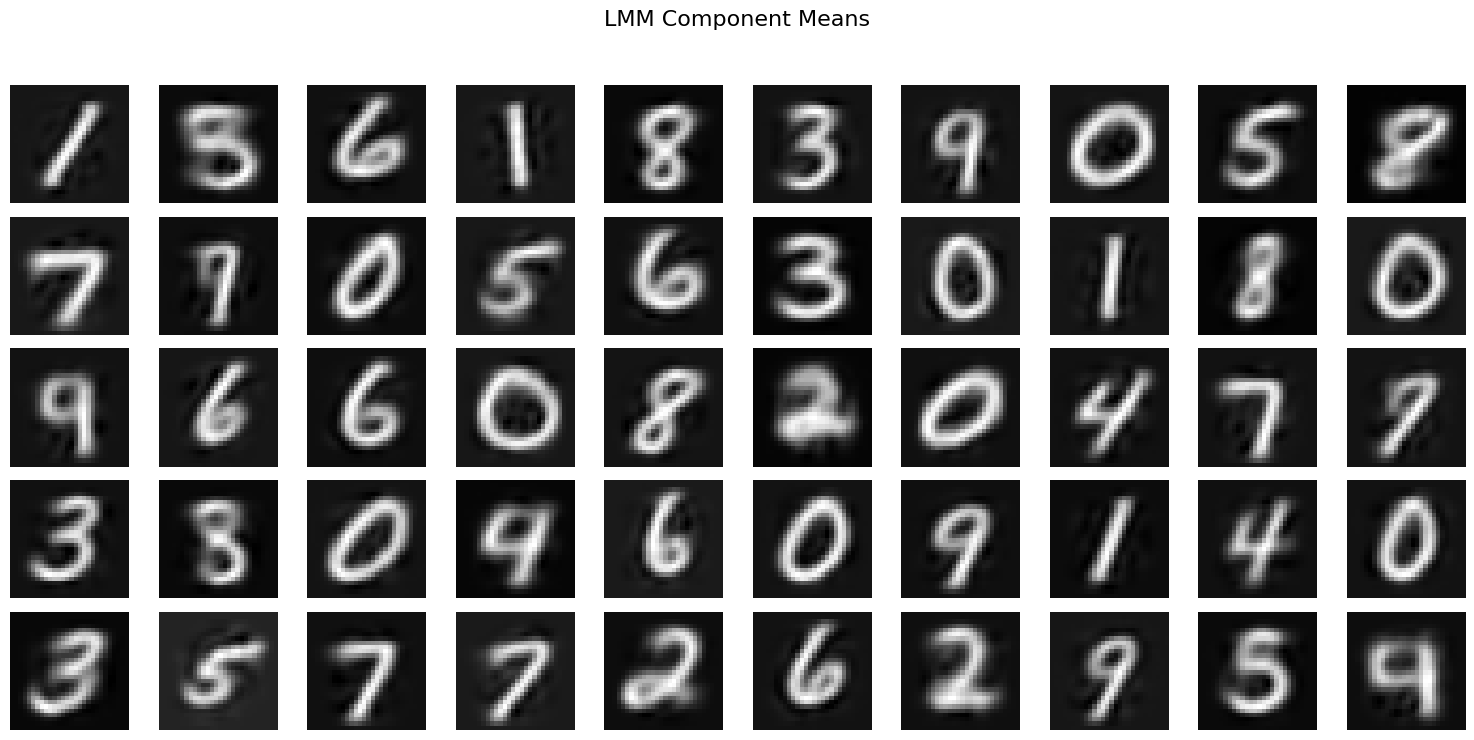

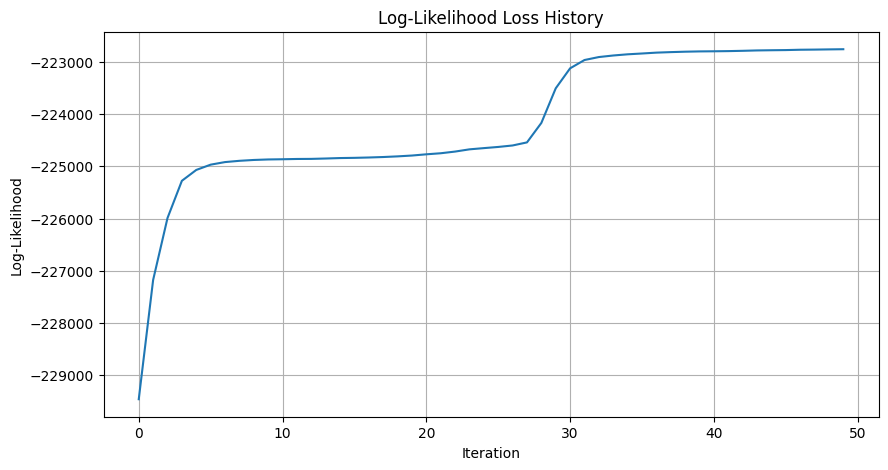

In [56]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import matplotlib.pyplot as plt
from tqdm import trange

class LaplacianMixtureModel:
    def __init__(self, n_components=10, max_iter=30, tol=1e-4, verbose=True):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _laplace_log_pdf(self, x, mu, b):
        return -np.log(2 * b + 1e-10) - np.abs(x - mu) / (b + 1e-10)

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        max_log_resp = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log_resp)
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            mu_k = np.zeros(D)
            for d in range(D):
                sorted_idx = np.argsort(X[:, d])
                sorted_X = X[sorted_idx, d]
                sorted_weights = resp[sorted_idx, k]
                cum_weights = np.cumsum(sorted_weights)
                median_idx = np.searchsorted(cum_weights, Nk[k] / 2)
                mu_k[d] = sorted_X[median_idx]
            self.mu[k] = mu_k
            self.b[k] = np.sum(resp[:, k][:, None] * np.abs(X - self.mu[k]), axis=0) / Nk[k]
            self.b[k] = np.clip(self.b[k], 1e-3, None)

    def fit(self, X):
        N, D = X.shape
        rng = np.random.RandomState(42)
        self.mu = X[rng.choice(N, self.K, replace=False)]
        self.b = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training LMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_likelihood = np.sum(np.log(np.sum([
                    self.pi[k] * np.exp(np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1))
                    for k in range(self.K)
                ], axis=0) + 1e-10))
                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")
                self.loss_history.append(log_likelihood)

        self.resp = resp

    def predict(self, X):
        log_resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        return np.argmax(log_resp, axis=1)

    def plot_components(self, pca):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.5 * n_cols, 1.5 * n_rows))
        axes = axes.flatten()

        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')

        for k in range(self.K, len(axes)):
            axes[k].axis('off')

        plt.suptitle("LMM Component Means", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.title("Log-Likelihood Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid()
        plt.show()

# Load MNIST
dataset = fetch_openml("mnist_784", version=1)
X = dataset.data / 255.0
y = dataset.target.astype(int)

# Subset and PCA
X_train = X[:10000]
y_train = y[:10000]
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Train LMM
lmm = LaplacianMixtureModel(n_components=50, max_iter=50, verbose=True)
lmm.fit(X_train_pca)

# Predict clusters
y_pred = lmm.predict(X_train_pca)

# Mode-based labeling
label_map = {}
for k in range(lmm.K):
    cluster_points = y_train[y_pred == k]
    if len(cluster_points) > 0:
        most_common = mode(cluster_points, keepdims=False).mode
        label_map[k] = int(most_common)
    else:
        label_map[k] = -1

mapped_preds = np.array([label_map.get(cluster, -1) for cluster in y_pred])

# Accuracy
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nMapped Clustering Accuracy: {accuracy * 100:.2f}%")

# Visualize components and loss
lmm.plot_components(pca)
lmm.plot_loss()

Iter 50 | LogL: -222114.47: 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]



Mapped Clustering Accuracy: 79.55%


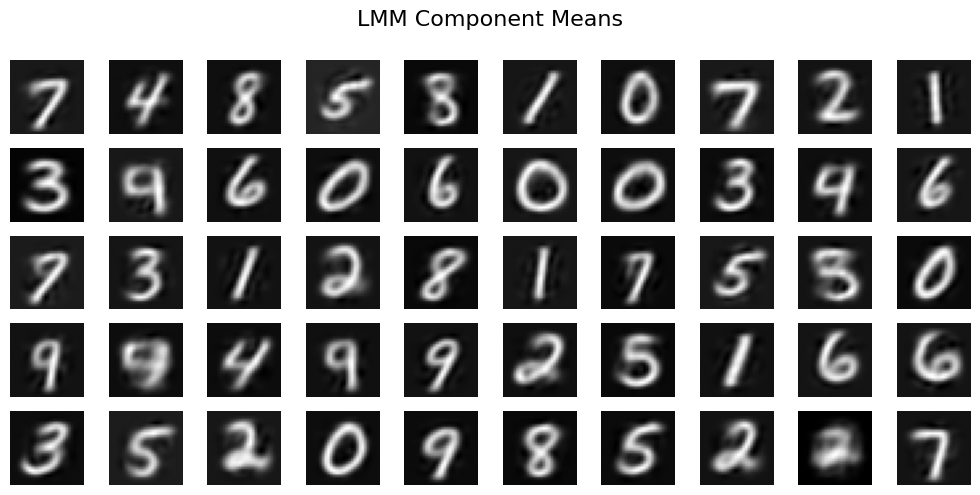

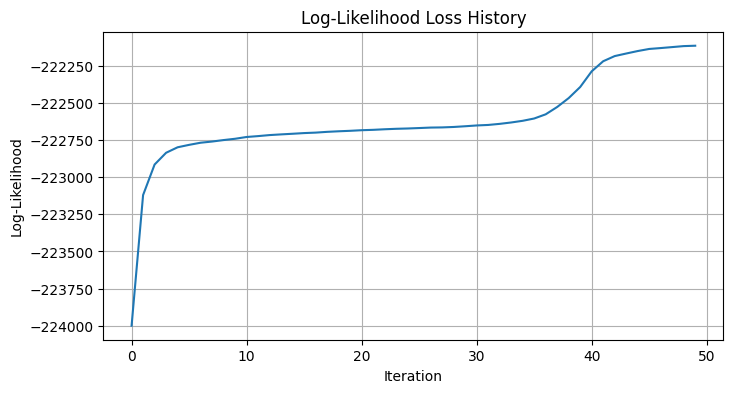

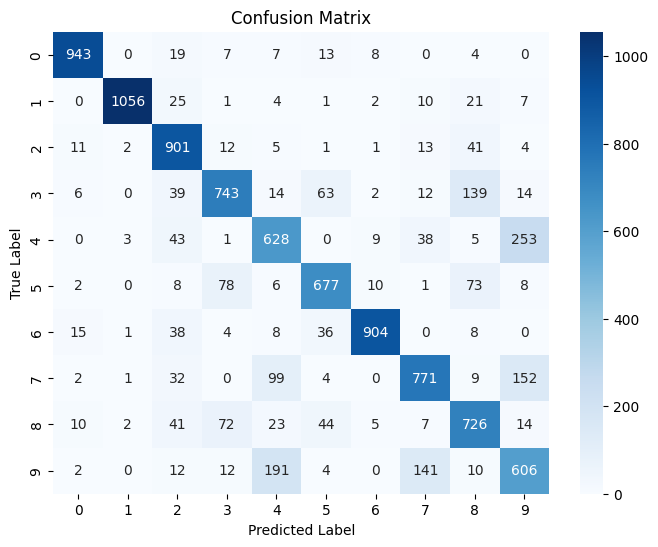

In [15]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.cluster import KMeans

class LaplacianMixtureModel:
    def __init__(self, n_components=10, max_iter=30, tol=1e-4, verbose=True):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _laplace_log_pdf(self, x, mu, b):
        return -np.log(2 * b + 1e-10) - np.abs(x - mu) / (b + 1e-10)

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        max_log_resp = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log_resp)
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            mu_k = np.zeros(D)
            for d in range(D):
                sorted_idx = np.argsort(X[:, d])
                sorted_X = X[sorted_idx, d]
                sorted_weights = resp[sorted_idx, k]
                cum_weights = np.cumsum(sorted_weights)
                median_idx = np.searchsorted(cum_weights, Nk[k] / 2)
                mu_k[d] = sorted_X[median_idx]
            self.mu[k] = mu_k
            self.b[k] = np.sum(resp[:, k][:, None] * np.abs(X - self.mu[k]), axis=0) / Nk[k]
            self.b[k] = np.clip(self.b[k], 1e-3, None)

    def fit(self, X):
        N, D = X.shape
        km = KMeans(n_clusters=self.K, init='k-means++', n_init=10).fit(X)
        self.mu = km.cluster_centers_
        self.b = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training LMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_likelihood = np.sum(np.log(np.sum([
                    self.pi[k] * np.exp(np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1))
                    for k in range(self.K)
                ], axis=0) + 1e-10))
                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")
                self.loss_history.append(log_likelihood)

        self.resp = resp

    def predict(self, X):
        log_resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        return np.argmax(log_resp, axis=1)
    
    def sample(self, n_samples=10):
        samples = []
        component_ids = np.random.choice(self.K, size=n_samples, p=self.pi)

        for k in component_ids:
            mu_k = self.mu[k]
            b_k = self.b[k]

            # Sample from Laplace using inverse transform sampling
            u = np.random.uniform(low=-0.5, high=0.5, size=mu_k.shape)
            x = mu_k - b_k * np.sign(u) * np.log(1 - 2 * np.abs(u))
            samples.append(x)

        return np.array(samples), component_ids

    def plot_components(self, pca):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1 * n_cols, 1 * n_rows))
        axes = axes.flatten()

        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')

        for k in range(self.K, len(axes)):
            axes[k].axis('off')

        plt.suptitle("LMM Component Means", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

    def plot_loss(self, figsize=(10, 5)):
        plt.figure(figsize=figsize)
        plt.plot(self.loss_history)
        plt.title("Log-Likelihood Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid()
        plt.show()

# Load MNIST
mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

# Subset and PCA
X_train = X[:10000]
y_train = y[:10000]
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Train LMM
lmm = LaplacianMixtureModel(n_components=50, max_iter=50, verbose=True)
lmm.fit(X_train_pca)

# Predict clusters
y_pred = lmm.predict(X_train_pca)

# Simple mode mapping
label_map = {}
for k in range(lmm.K):
    cluster_points = y_train[y_pred == k]
    if len(cluster_points) > 0:
        most_common = mode(cluster_points, keepdims=False).mode
        label_map[k] = int(most_common)
    else:
        label_map[k] = -1
mapped_preds = np.array([label_map.get(cluster, -1) for cluster in y_pred])

# Accuracy
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nMapped Clustering Accuracy: {accuracy * 100:.2f}%")

# Visualize components and loss
lmm.plot_components(pca)
lmm.plot_loss((8, 4))

# Compute the confusion matrix
conf_mat = confusion_matrix(y_train, mapped_preds, labels=np.arange(10))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Test Accuracy: 76.81%


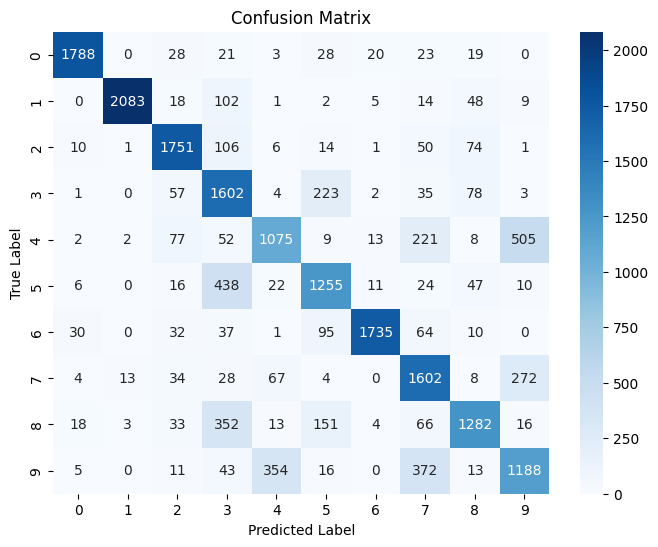

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X[20000:40000]
y_test = y[20000:40000]

# Step 8: Apply same PCA transform
X_test_pca = pca.transform(X_test)

# Step 9: Predict clusters using the trained LMM
y_test_pred = lmm.predict(X_test_pca)

# Step 10: Map predicted clusters to digits using training-time label_map
y_test_mapped = np.array([label_map.get(cluster, -1) for cluster in y_test_pred])

# Step 11: Evaluate accuracy
test_accuracy = accuracy_score(y_test, y_test_mapped)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Compute the confusion matrix
conf_mat_test = confusion_matrix(y_test, y_test_mapped, labels=np.arange(10))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
import numpy as np
from tqdm import trange
from scipy.special import loggamma as gammaln

class StudentTMixtureModel:
    def __init__(self, n_components=10, max_iter=50, tol=1e-4, verbose=True, nu=5):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.nu = nu  # degrees of freedom (can be made learnable too)

    def _student_t_log_pdf(self, x, mu, var):
        D = x.shape[1]
        nu = self.nu
        diff = x - mu
        inv_var = 1.0 / var
        quad_form = np.sum(diff**2 * inv_var, axis=1)
        log_det = np.sum(np.log(var + 1e-10))
        log_prob = (
            gammaln((nu + D) / 2)
            - gammaln(nu / 2)
            - 0.5 * log_det
            - (D / 2) * np.log(nu * np.pi)
            - ((nu + D) / 2) * np.log(1 + quad_form / nu)
        )

        return log_prob

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            log_pdf = self._student_t_log_pdf(X, self.mu[k], self.var[k])
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        max_log_resp = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log_resp)
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            r_k = resp[:, k][:, None]
            mu_k = np.sum(r_k * X, axis=0) / Nk[k]
            diff = X - mu_k
            sigma2_k = np.sum(r_k * diff**2, axis=0) / Nk[k]
            self.mu[k] = mu_k
            self.var[k] = np.clip(sigma2_k, 1e-3, None)

    def fit(self, X):
        N, D = X.shape
        from sklearn.cluster import KMeans
        km = KMeans(n_clusters=self.K, init='k-means++', n_init=10).fit(X)
        self.mu = km.cluster_centers_
        self.var = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training TMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_likelihood = np.sum(np.log(np.sum([
                    self.pi[k] * np.exp(self._student_t_log_pdf(X, self.mu[k], self.var[k]))
                    for k in range(self.K)
                ], axis=0) + 1e-10))
                self.loss_history.append(log_likelihood)
                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")

        self.resp = resp
        
    def plot_components(self, pca):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1 * n_cols, 1 * n_rows))
        axes = axes.flatten()

        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')

        for k in range(self.K, len(axes)):
            axes[k].axis('off')

        plt.suptitle("TMM Component Means", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

    def predict(self, X):
        log_resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + self._student_t_log_pdf(X, self.mu[k], self.var[k])
        return np.argmax(log_resp, axis=1)

    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.title("TMM Log-Likelihood Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid()
        plt.show()

Iter 100 | LogL: -442843.97: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]



Mapped Clustering Accuracy (TMM): 81.16%


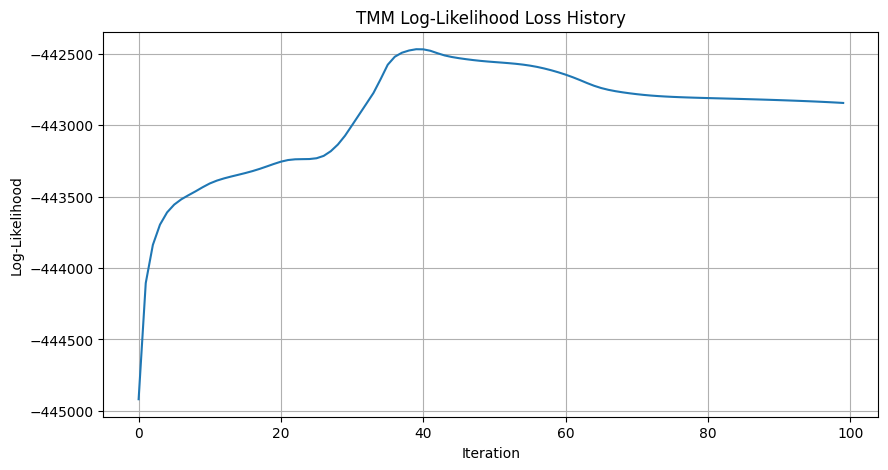

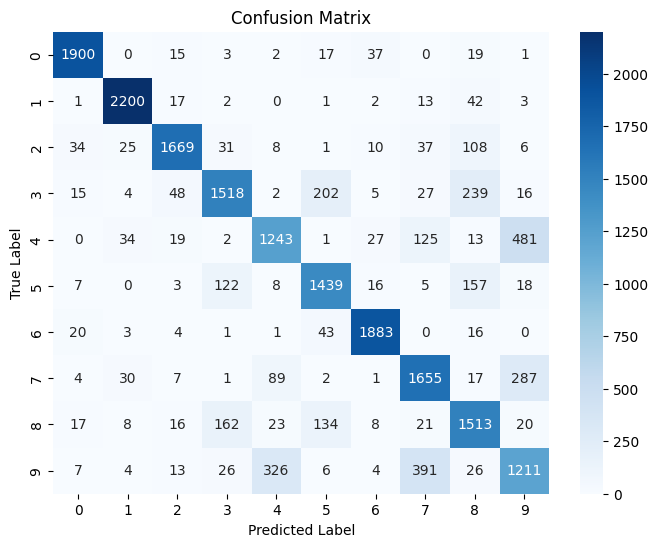

In [26]:
X_train = X[:20000]
y_train = y[:20000]
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)

# Train TMM
tmm = StudentTMixtureModel(n_components=50, max_iter=100, verbose=True)
tmm.fit(X_train_pca)

# Predict clusters
y_pred = tmm.predict(X_train_pca)

# Map predictions to labels using mode
label_map = {}
for k in range(tmm.K):
    cluster_points = y_train[y_pred == k]
    if len(cluster_points) > 0:
        most_common = mode(cluster_points, keepdims=False).mode
        label_map[k] = int(most_common)
    else:
        label_map[k] = -1
mapped_preds = np.array([label_map.get(cluster, -1) for cluster in y_pred])

# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, mapped_preds)
print(f"\nMapped Clustering Accuracy (TMM): {accuracy * 100:.2f}%")

# Plot loss
tmm.plot_loss()

conf_mat = confusion_matrix(y_train, mapped_preds, labels=np.arange(10))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


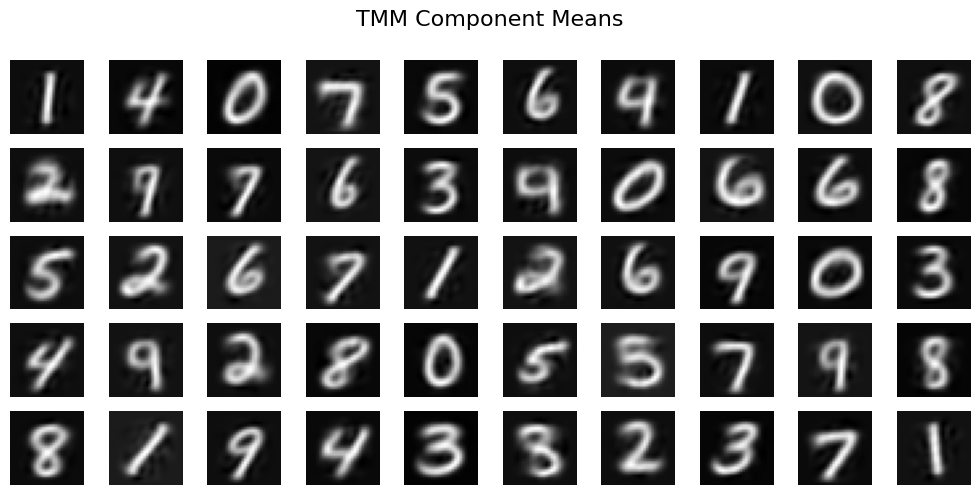

In [27]:
tmm.plot_components(pca)


Test Accuracy (TMM): 80.27%


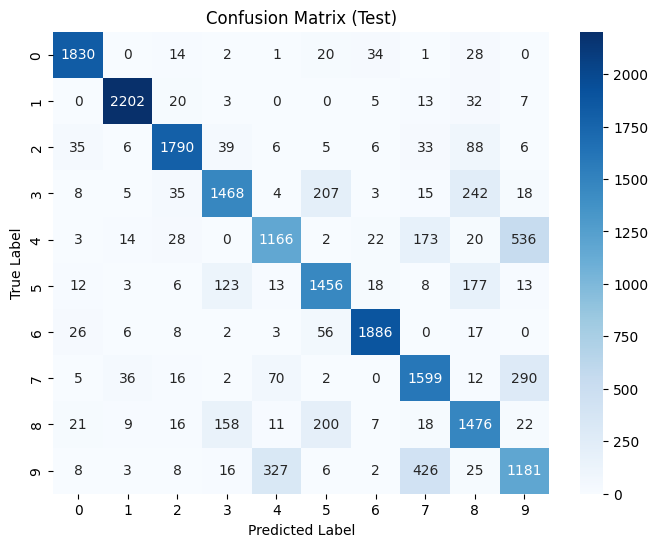

In [28]:
X_test = X[20000:40000]
y_test = y[20000:40000]
X_test_pca = pca.transform(X_test)
y_test_pred = tmm.predict(X_test_pca)

y_test_mapped = np.array([label_map.get(cluster, -1) for cluster in y_test_pred])
test_accuracy = accuracy_score(y_test, y_test_mapped)

print(f"\nTest Accuracy (TMM): {test_accuracy * 100:.2f}%")

conf_mat_test = confusion_matrix(y_test, y_test_mapped, labels=np.arange(10))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test)")
plt.show()